In [1]:
ls

helper_codes/     LearningNotebook.ipynb  mlruns/  requirements.txt
Homework-2.ipynb  mlflow.db               output/


In [2]:
!python -V

Python 3.9.12


- `-f` checks if the given path exists and is a regular file (just `-e` checks if the path exists)
- the `[]` perform the test and returns `0` on success, `1` otherwise
- the `||` is a C-like or, so if the command on the left fails, execute the command on the right.

In [3]:
# 
![ -f fhv_tripdata_2021-01.parquet ] || echo "noice" # it's no available so noice output
![ -f ../data/fhv_tripdata_2021-01.parquet ] || wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet -O ../data/fhv_tripdata_2021-01.parquet
![ -f ../data/fhv_tripdata_2021-02.parquet ] || wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet -O ../data/fhv_tripdata_2021-02.parquet

noice


In [4]:
# !wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet -O ../data/fhv_tripdata_2021-01.parquet
# !wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet -O ../data/fhv_tripdata_2021-02.parquet    

In [5]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
# new
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
!pip install pyarrow

In [8]:
df_jan = pd.read_parquet('../data/fhv_tripdata_2021-01.parquet')
df_jan.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


# Question 1: Number of records in Jan 2021 FHV data
**1154112**

In [9]:
df_jan.shape

(1154112, 7)

# Question 2: Average duration in Jan 2021 FHV
**19.16**

In [10]:
df_jan['duration'] = df_jan.dropOff_datetime - df_jan.pickup_datetime

In [11]:
df_jan.duration.describe()

count                      1154112
mean     0 days 00:19:10.033445627
std      0 days 06:38:41.529882844
min                0 days 00:00:01
25%                0 days 00:07:46
50%                0 days 00:13:24
75%                0 days 00:22:17
max              294 days 00:11:03
Name: duration, dtype: object

In [12]:
df_jan.dtypes

dispatching_base_num               object
pickup_datetime            datetime64[ns]
dropOff_datetime           datetime64[ns]
PUlocationID                      float64
DOlocationID                      float64
SR_Flag                            object
Affiliated_base_number             object
duration                  timedelta64[ns]
dtype: object

In [13]:
df_jan.duration = df_jan.duration.apply(lambda t: t.total_seconds() / 60)

In [14]:
df_jan.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

In [15]:
len(df_jan)

1154112

/home/mikeyy/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

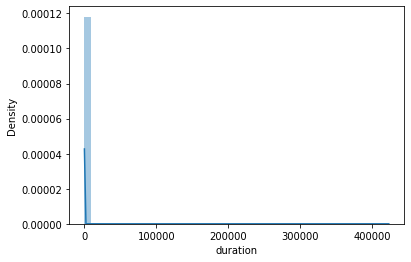

In [16]:
sns.distplot(df_jan.duration)

In [17]:
df_jan.duration.describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

In [18]:
df_jan = df_jan[(df_jan.duration >= 1) & (df_jan.duration <= 60)]

In [19]:
len(df_jan)

1109826

## Number of records Dropped
44286

In [20]:
1154112 - 1109826

44286

In [21]:
df_jan.duration.describe()

count    1.109826e+06
mean     1.624725e+01
std      1.155150e+01
min      1.000000e+00
25%      7.850000e+00
50%      1.323333e+01
75%      2.146667e+01
max      6.000000e+01
Name: duration, dtype: float64

# Question 3: Fraction of missing values
**83%**

In [22]:
df_jan.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037,9.050000


In [23]:
df_jan.columns.tolist()

['dispatching_base_num',
 'pickup_datetime',
 'dropOff_datetime',
 'PUlocationID',
 'DOlocationID',
 'SR_Flag',
 'Affiliated_base_number',
 'duration']

In [24]:
df_jan.PUlocationID.isnull().sum()

927008

In [25]:
len(df_jan.PUlocationID)

1109826

In [26]:
958267 / 1154112

0.8303067639882438

In [27]:
df_jan.PUlocationID = df_jan.PUlocationID.fillna(-1)

In [28]:
df_jan.PUlocationID.value_counts()

-1.0      927008
 221.0      8330
 206.0      6797
 129.0      5379
 115.0      4082
           ...  
 111.0         5
 27.0          4
 34.0          3
 2.0           2
 110.0         1
Name: PUlocationID, Length: 262, dtype: int64

In [29]:
# Convert to percentage
df_jan.PUlocationID.value_counts(normalize=True) * 100 

-1.0      83.527328
 221.0     0.750568
 206.0     0.612438
 129.0     0.484671
 115.0     0.367805
            ...    
 111.0     0.000451
 27.0      0.000360
 34.0      0.000270
 2.0       0.000180
 110.0     0.000090
Name: PUlocationID, Length: 262, dtype: float64

# Question 4: Dimensionality after OHE
--> apply one-hot encoding to the pickup and dropoff location IDs
* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer
* Get a feature matrix from it

**525**

In [30]:
def readdataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        
        df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
        df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
        
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda t: t.total_seconds() / 60)
    
    df = df[(df.duration >=1) & (df.duration <= 60)]
    
#     df.PUlocationID = df.PUlocationID.fillna(-1)
#     df.DOlocationID = df.DOlocationID.fillna(-1)
    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [31]:
df_jan.columns.to_list()

['dispatching_base_num',
 'pickup_datetime',
 'dropOff_datetime',
 'PUlocationID',
 'DOlocationID',
 'SR_Flag',
 'Affiliated_base_number',
 'duration']

In [32]:
df_train = readdataframe('../data/fhv_tripdata_2021-01.parquet')
df_val = readdataframe('../data/fhv_tripdata_2021-02.parquet')

In [33]:
len(df_train), len(df_val)

(1109826, 990113)

In [34]:
df_train.duration.value_counts()

15.000000    5562
24.000000    5236
10.000000    5184
12.000000    5042
8.750000     4991
             ... 
59.666667      10
55.983333      10
58.150000      10
59.883333      10
59.500000      10
Name: duration, Length: 3541, dtype: int64

In [35]:
df_train.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                      object
DOlocationID                      object
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

In [36]:
df_train['PU_DO'] = df_train['PUlocationID'] + '_' + df_train['DOlocationID']
df_val['PU_DO'] = df_val['PUlocationID'] + '_' + df_val['DOlocationID']

In [37]:
# categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
categorical = ['PUlocationID', 'DOlocationID']
dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [38]:
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

In [39]:
X_val

<990113x525 sparse matrix of type '<class 'numpy.float64'>'
	with 1980223 stored elements in Compressed Sparse Row format>

In [40]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

# Question 5: RMSE on train
**10.5**

In [41]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519427219633

/home/mikeyy/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mikeyy/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


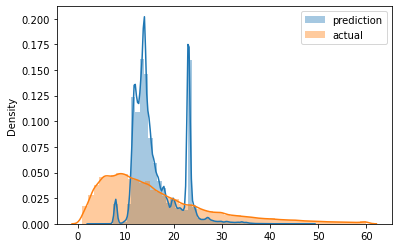

In [42]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

# Question 6: RMSE on validation
**11.01**

In [43]:
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.01428685575068

/home/mikeyy/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mikeyy/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


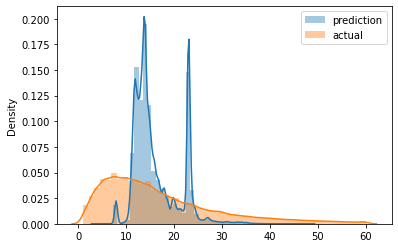

In [44]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()

# EXTRA THINGS 

## WITH LASSO

In [45]:
lr_las = Lasso(0.001)
lr_las.fit(X_train, y_train)

y_pred = lr_las.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.55747278112205

In [46]:
y_pred = lr_las.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.040500218391088

## WITH RIDGE

In [47]:
lr_rid = Ridge(alpha=0.001)
lr_rid.fit(X_train, y_train)

y_pred = lr_rid.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528754153207595

In [48]:
y_pred = lr_rid.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.014248381893537

# Using Mlflow

In [49]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "mikeyy")
    
    mlflow.log_param("train-data-path", "../data/fhv_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "../data/fhv_tripdata_2021-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr_las = Lasso(alpha=alpha)
    lr_las.fit(X_train, y_train)

    y_pred = lr_las.predict(X_train)

    rmse = mean_squared_error(y_train, y_pred, squared=False)
    
    mlflow.log_metric("rmse", rmse)

## SAVING THE BEST MODEL 

In [50]:
!mkdir ../models 

mkdir: cannot create directory ‘../models’: File exists


In [51]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [52]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [53]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [54]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=200,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
    
    return {"loss": rmse, "status": STATUS_OK}

In [55]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3) to exp(0) 
    'reg_alpha': hp.loguniform("reg_alpha", -5, -1),
    'reg_lambda': hp.loguniform("reg_lambda", -6, -1),
    'min_child_weight': hp.loguniform("min_child_weight", -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

In [56]:
# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=Trials()
# )

[15:19:31] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17.80637                                                    
[1]	validation-rmse:15.95205                                                    
[2]	validation-rmse:14.57195                                                    
[3]	validation-rmse:13.56267                                                    
[4]	validation-rmse:12.82534                                                    
[5]	validation-rmse:12.30059                                                    
[6]	validation-rmse:11.92556                                                    
[7]	validation-rmse:11.65391                                                    
[8]	validation-rmse:11.46357                                                    
[9]	validation-rmse:11.32210                                                    
[10]	validation-rmse:11.21708                                          

[99]	validation-rmse:10.67400                                                   
[100]	validation-rmse:10.67339                                                  
[101]	validation-rmse:10.67268                                                  
[102]	validation-rmse:10.67220                                                  
[103]	validation-rmse:10.67192                                                  
[104]	validation-rmse:10.67130                                                  
[105]	validation-rmse:10.67058                                                  
[106]	validation-rmse:10.66813                                                  
[107]	validation-rmse:10.66774                                                  
[108]	validation-rmse:10.66724                                                  
[109]	validation-rmse:10.66682                                                  
[110]	validation-rmse:10.66558                                                  
[111]	validation-rmse:10.664

[15:21:26] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.69699                                                    
[1]	validation-rmse:17.37059                                                    
[2]	validation-rmse:16.25387                                                    
[3]	validation-rmse:15.31636                                                    
[4]	validation-rmse:14.53714                                                    
[5]	validation-rmse:13.88919                                                    
[6]	validation-rmse:13.35789                                                    
[7]	validation-rmse:12.92191                                                    
[8]	validation-rmse:12.56217                                                    
[9]	validation-rmse:12.27089                                                    
[10]	validation-rmse:12.03092                                          

[99]	validation-rmse:10.76584                                                   
[100]	validation-rmse:10.76536                                                  
[101]	validation-rmse:10.76500                                                  
[102]	validation-rmse:10.76397                                                  
[103]	validation-rmse:10.76339                                                  
[104]	validation-rmse:10.76032                                                  
[105]	validation-rmse:10.75878                                                  
[106]	validation-rmse:10.75739                                                  
[107]	validation-rmse:10.75633                                                  
[108]	validation-rmse:10.75588                                                  
[109]	validation-rmse:10.75522                                                  
[110]	validation-rmse:10.75442                                                  
[111]	validation-rmse:10.752

[15:23:22] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.10594                                                    
[1]	validation-rmse:18.07973                                                    
[2]	validation-rmse:17.16966                                                    
[3]	validation-rmse:16.36665                                                    
[4]	validation-rmse:15.65948                                                    
[5]	validation-rmse:15.03978                                                    
[6]	validation-rmse:14.49709                                                    
[7]	validation-rmse:14.02151                                                    
[8]	validation-rmse:13.60992                                                    
[9]	validation-rmse:13.25066                                                    
[10]	validation-rmse:12.94059                                          

[99]	validation-rmse:10.75358                                                   
[100]	validation-rmse:10.75138                                                  
[101]	validation-rmse:10.75058                                                  
[102]	validation-rmse:10.74847                                                  
[103]	validation-rmse:10.74643                                                  
[104]	validation-rmse:10.74486                                                  
[105]	validation-rmse:10.74370                                                  
[106]	validation-rmse:10.74302                                                  
[107]	validation-rmse:10.74179                                                  
[108]	validation-rmse:10.74041                                                  
[109]	validation-rmse:10.73830                                                  
[110]	validation-rmse:10.73709                                                  
[111]	validation-rmse:10.736

[15:25:15] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.83704                                                    
[1]	validation-rmse:12.45232                                                    
[2]	validation-rmse:11.48032                                                    
[3]	validation-rmse:11.06733                                                    
[4]	validation-rmse:10.89063                                                    
[5]	validation-rmse:10.80002                                                    
[6]	validation-rmse:10.75754                                                    
[7]	validation-rmse:10.72845                                                    
[8]	validation-rmse:10.71017                                                    
[9]	validation-rmse:10.69587                                                    
[10]	validation-rmse:10.68508                                          

[2]	validation-rmse:16.99242                                                    
[3]	validation-rmse:16.15180                                                    
[4]	validation-rmse:15.41569                                                    
[5]	validation-rmse:14.77573                                                    
[6]	validation-rmse:14.21691                                                    
[7]	validation-rmse:13.73146                                                    
[8]	validation-rmse:13.31198                                                    
[9]	validation-rmse:12.95149                                                    
[10]	validation-rmse:12.63875                                                   
[11]	validation-rmse:12.36881                                                   
[12]	validation-rmse:12.13769                                                   
[13]	validation-rmse:11.94063                                                   
[14]	validation-rmse:11.7730

[103]	validation-rmse:10.60620                                                  
[104]	validation-rmse:10.60575                                                  
[105]	validation-rmse:10.60538                                                  
[106]	validation-rmse:10.60483                                                  
[107]	validation-rmse:10.60385                                                  
[108]	validation-rmse:10.60347                                                  
[109]	validation-rmse:10.60312                                                  
[110]	validation-rmse:10.60291                                                  
[111]	validation-rmse:10.60277                                                  
[112]	validation-rmse:10.60258                                                  
[113]	validation-rmse:10.60238                                                  
[114]	validation-rmse:10.60220                                                  
[115]	validation-rmse:10.602

[2]	validation-rmse:11.35285                                                    
[3]	validation-rmse:11.00564                                                    
[4]	validation-rmse:10.86543                                                    
[5]	validation-rmse:10.80075                                                    
[6]	validation-rmse:10.75588                                                    
[7]	validation-rmse:10.72921                                                    
[8]	validation-rmse:10.70873                                                    
[9]	validation-rmse:10.69435                                                    
[10]	validation-rmse:10.68268                                                   
[11]	validation-rmse:10.67168                                                   
[12]	validation-rmse:10.66481                                                   
[13]	validation-rmse:10.65320                                                   
[14]	validation-rmse:10.6479

[103]	validation-rmse:10.59810                                                  
[104]	validation-rmse:10.59823                                                  
[105]	validation-rmse:10.59804                                                  
[106]	validation-rmse:10.59792                                                  
[107]	validation-rmse:10.59782                                                  
[108]	validation-rmse:10.59773                                                  
[109]	validation-rmse:10.59776                                                  
[110]	validation-rmse:10.59766                                                  
[111]	validation-rmse:10.59763                                                  
[112]	validation-rmse:10.59763                                                  
[113]	validation-rmse:10.59740                                                  
[114]	validation-rmse:10.59733                                                  
[115]	validation-rmse:10.597

[2]	validation-rmse:16.11679                                                    
[3]	validation-rmse:15.16439                                                    
[4]	validation-rmse:14.37572                                                    
[5]	validation-rmse:13.72948                                                    
[6]	validation-rmse:13.19681                                                    
[7]	validation-rmse:12.76416                                                    
[8]	validation-rmse:12.41354                                                    
[9]	validation-rmse:12.12636                                                    
[10]	validation-rmse:11.89304                                                   
[11]	validation-rmse:11.70557                                                   
[12]	validation-rmse:11.55342                                                   
[13]	validation-rmse:11.43060                                                   
[14]	validation-rmse:11.3302

[103]	validation-rmse:10.65415                                                  
[104]	validation-rmse:10.65310                                                  
[105]	validation-rmse:10.65131                                                  
[106]	validation-rmse:10.65068                                                  
[107]	validation-rmse:10.64979                                                  
[108]	validation-rmse:10.64843                                                  
[109]	validation-rmse:10.64807                                                  
[110]	validation-rmse:10.64745                                                  
[111]	validation-rmse:10.64680                                                  
[112]	validation-rmse:10.64585                                                  
[113]	validation-rmse:10.64461                                                  
[114]	validation-rmse:10.64418                                                  
[115]	validation-rmse:10.643

[2]	validation-rmse:16.13242                                                    
[3]	validation-rmse:15.18461                                                    
[4]	validation-rmse:14.40327                                                    
[5]	validation-rmse:13.75875                                                    
[6]	validation-rmse:13.23431                                                    
[7]	validation-rmse:12.80738                                                    
[8]	validation-rmse:12.45816                                                    
[9]	validation-rmse:12.17696                                                    
[10]	validation-rmse:11.95141                                                   
[11]	validation-rmse:11.76924                                                   
[12]	validation-rmse:11.61819                                                   
[13]	validation-rmse:11.49632                                                   
[14]	validation-rmse:11.3965

[103]	validation-rmse:10.71395                                                  
[104]	validation-rmse:10.71308                                                  
[105]	validation-rmse:10.71156                                                  
[106]	validation-rmse:10.71094                                                  
[107]	validation-rmse:10.71018                                                  
[108]	validation-rmse:10.70808                                                  
[109]	validation-rmse:10.70757                                                  
[110]	validation-rmse:10.70630                                                  
[111]	validation-rmse:10.70485                                                  
[112]	validation-rmse:10.70397                                                  
[113]	validation-rmse:10.70280                                                  
[114]	validation-rmse:10.69982                                                  
[115]	validation-rmse:10.698

[2]	validation-rmse:18.28044                                                    
[3]	validation-rmse:17.70584                                                    
[4]	validation-rmse:17.17024                                                    
[5]	validation-rmse:16.67167                                                    
[6]	validation-rmse:16.20883                                                    
[7]	validation-rmse:15.77886                                                    
[8]	validation-rmse:15.37836                                                    
[9]	validation-rmse:15.00728                                                    
[10]	validation-rmse:14.66375                                                   
[11]	validation-rmse:14.34649                                                   
[12]	validation-rmse:14.05220                                                   
[13]	validation-rmse:13.78046                                                   
[14]	validation-rmse:13.5294

[103]	validation-rmse:10.60657                                                  
[104]	validation-rmse:10.60580                                                  
[105]	validation-rmse:10.60510                                                  
[106]	validation-rmse:10.60456                                                  
[107]	validation-rmse:10.60407                                                  
[108]	validation-rmse:10.60358                                                  
[109]	validation-rmse:10.60298                                                  
[110]	validation-rmse:10.60220                                                  
[111]	validation-rmse:10.60179                                                  
[112]	validation-rmse:10.60124                                                  
[113]	validation-rmse:10.60062                                                  
[114]	validation-rmse:10.60033                                                  
[115]	validation-rmse:10.599

[2]	validation-rmse:17.86776                                                    
[3]	validation-rmse:17.19933                                                    
[4]	validation-rmse:16.58728                                                    
[5]	validation-rmse:16.02935                                                    
[6]	validation-rmse:15.52097                                                    
[7]	validation-rmse:15.05794                                                    
[8]	validation-rmse:14.63946                                                    
[9]	validation-rmse:14.25806                                                    
[10]	validation-rmse:13.91184                                                   
[11]	validation-rmse:13.60144                                                   
[12]	validation-rmse:13.31890                                                   
[13]	validation-rmse:13.06421                                                   
[14]	validation-rmse:12.8368

[103]	validation-rmse:10.69571                                                  
[104]	validation-rmse:10.69516                                                  
[105]	validation-rmse:10.69414                                                  
[106]	validation-rmse:10.69385                                                  
[107]	validation-rmse:10.69195                                                  
[108]	validation-rmse:10.69152                                                  
[109]	validation-rmse:10.69077                                                  
[110]	validation-rmse:10.68971                                                  
[111]	validation-rmse:10.68940                                                  
[112]	validation-rmse:10.68877                                                  
[113]	validation-rmse:10.68833                                                  
[114]	validation-rmse:10.68802                                                  
[115]	validation-rmse:10.687

[2]	validation-rmse:18.34821                                                    
[3]	validation-rmse:17.79233                                                    
[4]	validation-rmse:17.27436                                                    
[5]	validation-rmse:16.79131                                                    
[6]	validation-rmse:16.34199                                                    
[7]	validation-rmse:15.92454                                                    
[8]	validation-rmse:15.53626                                                    
[9]	validation-rmse:15.17662                                                    
[10]	validation-rmse:14.84261                                                   
[11]	validation-rmse:14.53395                                                   
[12]	validation-rmse:14.24809                                                   
[13]	validation-rmse:13.98424                                                   
[14]	validation-rmse:13.7397

[103]	validation-rmse:10.78185                                                  
[104]	validation-rmse:10.78066                                                  
[105]	validation-rmse:10.77857                                                  
[106]	validation-rmse:10.77677                                                  
[107]	validation-rmse:10.77536                                                  
[108]	validation-rmse:10.77329                                                  
[109]	validation-rmse:10.77180                                                  
[110]	validation-rmse:10.77010                                                  
[111]	validation-rmse:10.76875                                                  
[112]	validation-rmse:10.76713                                                  
[113]	validation-rmse:10.76575                                                  
[114]	validation-rmse:10.76473                                                  
[115]	validation-rmse:10.763

[2]	validation-rmse:11.49712                                                    
[3]	validation-rmse:11.31131                                                    
[4]	validation-rmse:11.22927                                                    
[5]	validation-rmse:11.18551                                                    
[6]	validation-rmse:11.15130                                                    
[7]	validation-rmse:11.12940                                                    
[8]	validation-rmse:11.11077                                                    
[9]	validation-rmse:11.09001                                                    
[10]	validation-rmse:11.07469                                                   
[11]	validation-rmse:11.06071                                                   
[12]	validation-rmse:11.04818                                                   
[13]	validation-rmse:11.03019                                                   
[14]	validation-rmse:11.0220

[103]	validation-rmse:10.72282                                                  
[104]	validation-rmse:10.72218                                                  
[105]	validation-rmse:10.72097                                                  
[106]	validation-rmse:10.72063                                                  
[107]	validation-rmse:10.71995                                                  
[108]	validation-rmse:10.71941                                                  
[109]	validation-rmse:10.71877                                                  
[110]	validation-rmse:10.71824                                                  
[111]	validation-rmse:10.71717                                                  
[112]	validation-rmse:10.71694                                                  
[113]	validation-rmse:10.71595                                                  
[114]	validation-rmse:10.71560                                                  
[115]	validation-rmse:10.715

[2]	validation-rmse:18.22233                                                    
[3]	validation-rmse:17.63694                                                    
[4]	validation-rmse:17.09447                                                    
[5]	validation-rmse:16.59161                                                    
[6]	validation-rmse:16.12697                                                    
[7]	validation-rmse:15.69753                                                    
[8]	validation-rmse:15.30185                                                    
[9]	validation-rmse:14.93587                                                    
[10]	validation-rmse:14.59950                                                   
[11]	validation-rmse:14.28950                                                   
[12]	validation-rmse:14.00602                                                   
[13]	validation-rmse:13.74392                                                   
[14]	validation-rmse:13.5051

[103]	validation-rmse:10.81029                                                  
[104]	validation-rmse:10.80860                                                  
[105]	validation-rmse:10.80708                                                  
[106]	validation-rmse:10.80548                                                  
[107]	validation-rmse:10.80351                                                  
[108]	validation-rmse:10.80192                                                  
[109]	validation-rmse:10.79996                                                  
[110]	validation-rmse:10.79894                                                  
[111]	validation-rmse:10.79710                                                  
[112]	validation-rmse:10.79585                                                  
[113]	validation-rmse:10.79455                                                  
[114]	validation-rmse:10.79345                                                  
[115]	validation-rmse:10.791

[2]	validation-rmse:11.66019                                                    
[3]	validation-rmse:11.17418                                                    
[4]	validation-rmse:10.95523                                                    
[5]	validation-rmse:10.84904                                                    
[6]	validation-rmse:10.79792                                                    
[7]	validation-rmse:10.76235                                                    
[8]	validation-rmse:10.73769                                                    
[9]	validation-rmse:10.72333                                                    
[10]	validation-rmse:10.71095                                                   
[11]	validation-rmse:10.69877                                                   
[12]	validation-rmse:10.69264                                                   
[13]	validation-rmse:10.68351                                                   
[14]	validation-rmse:10.6758

[103]	validation-rmse:10.61404                                                  
[104]	validation-rmse:10.61396                                                  
[105]	validation-rmse:10.61387                                                  
[106]	validation-rmse:10.61381                                                  
[107]	validation-rmse:10.61371                                                  
[108]	validation-rmse:10.61344                                                  
[109]	validation-rmse:10.61344                                                  
[110]	validation-rmse:10.61296                                                  
[111]	validation-rmse:10.61278                                                  
[112]	validation-rmse:10.61226                                                  
[113]	validation-rmse:10.61202                                                  
[114]	validation-rmse:10.61210                                                  
[115]	validation-rmse:10.612

[2]	validation-rmse:14.83364                                                    
[3]	validation-rmse:13.79065                                                    
[4]	validation-rmse:13.01084                                                    
[5]	validation-rmse:12.42575                                                    
[6]	validation-rmse:11.98835                                                    
[7]	validation-rmse:11.66893                                                    
[8]	validation-rmse:11.43396                                                    
[9]	validation-rmse:11.25518                                                    
[10]	validation-rmse:11.11946                                                   
[11]	validation-rmse:11.02221                                                   
[12]	validation-rmse:10.94544                                                   
[13]	validation-rmse:10.88917                                                   
[14]	validation-rmse:10.8437

[103]	validation-rmse:10.59947                                                  
[104]	validation-rmse:10.59951                                                  
[105]	validation-rmse:10.59945                                                  
[106]	validation-rmse:10.59945                                                  
[107]	validation-rmse:10.59951                                                  
[108]	validation-rmse:10.59955                                                  
[109]	validation-rmse:10.59956                                                  
[110]	validation-rmse:10.59962                                                  
[111]	validation-rmse:10.59969                                                  
[112]	validation-rmse:10.59973                                                  
[113]	validation-rmse:10.59976                                                  
[114]	validation-rmse:10.59982                                                  
[115]	validation-rmse:10.599

[50]	validation-rmse:10.59318                                                   
[51]	validation-rmse:10.59308                                                   
[52]	validation-rmse:10.59286                                                   
[53]	validation-rmse:10.59264                                                   
[54]	validation-rmse:10.59236                                                   
[55]	validation-rmse:10.59225                                                   
[56]	validation-rmse:10.59218                                                   
[57]	validation-rmse:10.59186                                                   
[58]	validation-rmse:10.59172                                                   
[59]	validation-rmse:10.59151                                                   
[60]	validation-rmse:10.59143                                                   
[61]	validation-rmse:10.59129                                                   
[62]	validation-rmse:10.5912

[151]	validation-rmse:10.58500                                                  
[152]	validation-rmse:10.58510                                                  
[153]	validation-rmse:10.58495                                                  
[154]	validation-rmse:10.58504                                                  
[155]	validation-rmse:10.58496                                                  
[156]	validation-rmse:10.58491                                                  
[157]	validation-rmse:10.58490                                                  
[158]	validation-rmse:10.58477                                                  
[159]	validation-rmse:10.58478                                                  
[160]	validation-rmse:10.58461                                                  
[161]	validation-rmse:10.58461                                                  
[162]	validation-rmse:10.58464                                                  
[163]	validation-rmse:10.584

[50]	validation-rmse:10.62359                                                   
[51]	validation-rmse:10.62211                                                   
[52]	validation-rmse:10.62044                                                   
[53]	validation-rmse:10.61923                                                   
[54]	validation-rmse:10.61815                                                   
[55]	validation-rmse:10.61742                                                   
[56]	validation-rmse:10.61645                                                   
[57]	validation-rmse:10.61615                                                   
[58]	validation-rmse:10.61477                                                   
[59]	validation-rmse:10.61376                                                   
[60]	validation-rmse:10.61308                                                   
[61]	validation-rmse:10.61286                                                   
[62]	validation-rmse:10.6116

[151]	validation-rmse:10.59445                                                  
[152]	validation-rmse:10.59442                                                  
[153]	validation-rmse:10.59440                                                  
[154]	validation-rmse:10.59439                                                  
[155]	validation-rmse:10.59439                                                  
[156]	validation-rmse:10.59433                                                  
[157]	validation-rmse:10.59432                                                  
[158]	validation-rmse:10.59432                                                  
[159]	validation-rmse:10.59416                                                  
[160]	validation-rmse:10.59417                                                  
[161]	validation-rmse:10.59415                                                  
[162]	validation-rmse:10.59413                                                  
[163]	validation-rmse:10.594

[50]	validation-rmse:11.15732                                                   
[51]	validation-rmse:11.15393                                                   
[52]	validation-rmse:11.15163                                                   
[53]	validation-rmse:11.14823                                                   
[54]	validation-rmse:11.14562                                                   
[55]	validation-rmse:11.14332                                                   
[56]	validation-rmse:11.13995                                                   
[57]	validation-rmse:11.13717                                                   
[58]	validation-rmse:11.13438                                                   
[59]	validation-rmse:11.13274                                                   
[60]	validation-rmse:11.13033                                                   
[61]	validation-rmse:11.12804                                                   
[62]	validation-rmse:11.1241

[151]	validation-rmse:10.98475                                                  
[152]	validation-rmse:10.98315                                                  
[153]	validation-rmse:10.98224                                                  
[154]	validation-rmse:10.98116                                                  
[155]	validation-rmse:10.98039                                                  
[156]	validation-rmse:10.97945                                                  
[157]	validation-rmse:10.97873                                                  
[158]	validation-rmse:10.97801                                                  
[159]	validation-rmse:10.97724                                                  
[160]	validation-rmse:10.97635                                                  
[161]	validation-rmse:10.97554                                                  
[162]	validation-rmse:10.97461                                                  
[163]	validation-rmse:10.973

[50]	validation-rmse:10.72081                                                   
[51]	validation-rmse:10.71785                                                   
[52]	validation-rmse:10.71596                                                   
[53]	validation-rmse:10.71358                                                   
[54]	validation-rmse:10.71129                                                   
[55]	validation-rmse:10.70899                                                   
[56]	validation-rmse:10.70757                                                   
[57]	validation-rmse:10.70637                                                   
[58]	validation-rmse:10.70392                                                   
[59]	validation-rmse:10.70227                                                   
[60]	validation-rmse:10.69855                                                   
[61]	validation-rmse:10.69715                                                   
[62]	validation-rmse:10.6945

[151]	validation-rmse:10.64179                                                  
[152]	validation-rmse:10.64119                                                  
[153]	validation-rmse:10.64091                                                  
[154]	validation-rmse:10.64082                                                  
[155]	validation-rmse:10.64075                                                  
[156]	validation-rmse:10.64058                                                  
[157]	validation-rmse:10.64051                                                  
[158]	validation-rmse:10.64042                                                  
[159]	validation-rmse:10.63994                                                  
[160]	validation-rmse:10.63990                                                  
[161]	validation-rmse:10.63982                                                  
[162]	validation-rmse:10.63970                                                  
[163]	validation-rmse:10.639

[50]	validation-rmse:11.28946                                                   
[51]	validation-rmse:11.28413                                                   
[52]	validation-rmse:11.27896                                                   
[53]	validation-rmse:11.27325                                                   
[54]	validation-rmse:11.26860                                                   
[55]	validation-rmse:11.26415                                                   
[56]	validation-rmse:11.26040                                                   
[57]	validation-rmse:11.25726                                                   
[58]	validation-rmse:11.25316                                                   
[59]	validation-rmse:11.24933                                                   
[60]	validation-rmse:11.24580                                                   
[61]	validation-rmse:11.24252                                                   
[62]	validation-rmse:11.2392

[151]	validation-rmse:11.09596                                                  
[152]	validation-rmse:11.09525                                                  
[153]	validation-rmse:11.09398                                                  
[154]	validation-rmse:11.09291                                                  
[155]	validation-rmse:11.09169                                                  
[156]	validation-rmse:11.09083                                                  
[157]	validation-rmse:11.08988                                                  
[158]	validation-rmse:11.08901                                                  
[159]	validation-rmse:11.08754                                                  
[160]	validation-rmse:11.08675                                                  
[161]	validation-rmse:11.08585                                                  
[162]	validation-rmse:11.08440                                                  
[163]	validation-rmse:11.083

[50]	validation-rmse:10.58579                                                   
[51]	validation-rmse:10.58510                                                   
[52]	validation-rmse:10.58542                                                   
[53]	validation-rmse:10.58519                                                   
[54]	validation-rmse:10.58506                                                   
[55]	validation-rmse:10.58500                                                   
[56]	validation-rmse:10.58483                                                   
[57]	validation-rmse:10.58457                                                   
[58]	validation-rmse:10.58469                                                   
[59]	validation-rmse:10.58476                                                   
[60]	validation-rmse:10.58449                                                   
[61]	validation-rmse:10.58442                                                   
[62]	validation-rmse:10.5843

[151]	validation-rmse:10.58166                                                  
[152]	validation-rmse:10.58177                                                  
[153]	validation-rmse:10.58166                                                  
[154]	validation-rmse:10.58167                                                  
[155]	validation-rmse:10.58171                                                  
[156]	validation-rmse:10.58165                                                  
[157]	validation-rmse:10.58137                                                  
[158]	validation-rmse:10.58154                                                  
[159]	validation-rmse:10.58159                                                  
[160]	validation-rmse:10.58127                                                  
[161]	validation-rmse:10.58128                                                  
[162]	validation-rmse:10.58175                                                  
[163]	validation-rmse:10.581

[50]	validation-rmse:10.59359                                                   
[51]	validation-rmse:10.59360                                                   
[52]	validation-rmse:10.59325                                                   
[53]	validation-rmse:10.59316                                                   
[54]	validation-rmse:10.59309                                                   
[55]	validation-rmse:10.59274                                                   
[56]	validation-rmse:10.59302                                                   
[57]	validation-rmse:10.59290                                                   
[58]	validation-rmse:10.59290                                                   
[59]	validation-rmse:10.59250                                                   
[60]	validation-rmse:10.59274                                                   
[61]	validation-rmse:10.59255                                                   
[62]	validation-rmse:10.5921

[151]	validation-rmse:10.58557                                                  
[152]	validation-rmse:10.58562                                                  
[153]	validation-rmse:10.58567                                                  
[154]	validation-rmse:10.58572                                                  
[155]	validation-rmse:10.58554                                                  
[156]	validation-rmse:10.58541                                                  
[157]	validation-rmse:10.58540                                                  
[158]	validation-rmse:10.58529                                                  
[159]	validation-rmse:10.58535                                                  
[160]	validation-rmse:10.58526                                                  
[161]	validation-rmse:10.58521                                                  
[162]	validation-rmse:10.58523                                                  
[163]	validation-rmse:10.585

[50]	validation-rmse:10.61303                                                   
[51]	validation-rmse:10.61303                                                   
[52]	validation-rmse:10.61303                                                   
[53]	validation-rmse:10.61303                                                   
[54]	validation-rmse:10.61303                                                   
[55]	validation-rmse:10.61303                                                   
[56]	validation-rmse:10.61303                                                   
[57]	validation-rmse:10.61303                                                   
[58]	validation-rmse:10.61303                                                   
[59]	validation-rmse:10.61303                                                   
[60]	validation-rmse:10.61303                                                   
[61]	validation-rmse:10.61303                                                   
[62]	validation-rmse:10.6130

[86]	validation-rmse:10.58270                                                   
[87]	validation-rmse:10.58267                                                   
[88]	validation-rmse:10.58267                                                   
[89]	validation-rmse:10.58272                                                   
[90]	validation-rmse:10.58267                                                   
[91]	validation-rmse:10.58266                                                   
[92]	validation-rmse:10.58271                                                   
[93]	validation-rmse:10.58264                                                   
[94]	validation-rmse:10.58260                                                   
[95]	validation-rmse:10.58258                                                   
[96]	validation-rmse:10.58262                                                   
[97]	validation-rmse:10.58257                                                   
[98]	validation-rmse:10.5824

[187]	validation-rmse:10.58045                                                  
[188]	validation-rmse:10.58043                                                  
[189]	validation-rmse:10.58043                                                  
[190]	validation-rmse:10.58043                                                  
[191]	validation-rmse:10.58043                                                  
[192]	validation-rmse:10.58033                                                  
[193]	validation-rmse:10.58030                                                  
[194]	validation-rmse:10.58024                                                  
[195]	validation-rmse:10.58024                                                  
[196]	validation-rmse:10.58029                                                  
[197]	validation-rmse:10.58024                                                  
[198]	validation-rmse:10.58018                                                  
[199]	validation-rmse:10.580

[86]	validation-rmse:10.58367                                                   
[87]	validation-rmse:10.58357                                                   
[88]	validation-rmse:10.58356                                                   
[89]	validation-rmse:10.58356                                                   
[90]	validation-rmse:10.58353                                                   
[91]	validation-rmse:10.58351                                                   
[92]	validation-rmse:10.58351                                                   
[93]	validation-rmse:10.58354                                                   
[94]	validation-rmse:10.58340                                                   
[95]	validation-rmse:10.58344                                                   
[96]	validation-rmse:10.58337                                                   
[97]	validation-rmse:10.58333                                                   
[98]	validation-rmse:10.5833

[187]	validation-rmse:10.58125                                                  
[188]	validation-rmse:10.58122                                                  
[189]	validation-rmse:10.58119                                                  
[190]	validation-rmse:10.58112                                                  
[191]	validation-rmse:10.58115                                                  
[192]	validation-rmse:10.58111                                                  
[193]	validation-rmse:10.58108                                                  
[194]	validation-rmse:10.58108                                                  
[195]	validation-rmse:10.58110                                                  
[196]	validation-rmse:10.58107                                                  
[197]	validation-rmse:10.58102                                                  
[198]	validation-rmse:10.58099                                                  
[199]	validation-rmse:10.581

[86]	validation-rmse:10.58410                                                   
[87]	validation-rmse:10.58387                                                   
[88]	validation-rmse:10.58371                                                   
[89]	validation-rmse:10.58366                                                   
[90]	validation-rmse:10.58353                                                   
[91]	validation-rmse:10.58360                                                   
[92]	validation-rmse:10.58360                                                   
[93]	validation-rmse:10.58348                                                   
[94]	validation-rmse:10.58342                                                   
[95]	validation-rmse:10.58355                                                   
[96]	validation-rmse:10.58344                                                   
[97]	validation-rmse:10.58344                                                   
[98]	validation-rmse:10.5833

[187]	validation-rmse:10.58128                                                  
[188]	validation-rmse:10.58137                                                  
[189]	validation-rmse:10.58135                                                  
[190]	validation-rmse:10.58143                                                  
[191]	validation-rmse:10.58133                                                  
[192]	validation-rmse:10.58123                                                  
[193]	validation-rmse:10.58123                                                  
[194]	validation-rmse:10.58126                                                  
[195]	validation-rmse:10.58131                                                  
[196]	validation-rmse:10.58123                                                  
[197]	validation-rmse:10.58125                                                  
[198]	validation-rmse:10.58119                                                  
[199]	validation-rmse:10.581

[86]	validation-rmse:10.58210                                                   
[87]	validation-rmse:10.58217                                                   
[88]	validation-rmse:10.58219                                                   
[89]	validation-rmse:10.58204                                                   
[90]	validation-rmse:10.58201                                                   
[91]	validation-rmse:10.58203                                                   
[92]	validation-rmse:10.58199                                                   
[93]	validation-rmse:10.58203                                                   
[94]	validation-rmse:10.58208                                                   
[95]	validation-rmse:10.58218                                                   
[96]	validation-rmse:10.58208                                                   
[97]	validation-rmse:10.58204                                                   
[98]	validation-rmse:10.5820

[187]	validation-rmse:10.57959                                                  
[188]	validation-rmse:10.57954                                                  
[189]	validation-rmse:10.57950                                                  
[190]	validation-rmse:10.57946                                                  
[191]	validation-rmse:10.57945                                                  
[192]	validation-rmse:10.57944                                                  
[193]	validation-rmse:10.57944                                                  
[194]	validation-rmse:10.57944                                                  
[195]	validation-rmse:10.57939                                                  
[196]	validation-rmse:10.57935                                                  
[197]	validation-rmse:10.57942                                                  
[198]	validation-rmse:10.57932                                                  
[199]	validation-rmse:10.579

[16:52:48] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.85906                                                    
[1]	validation-rmse:14.60255                                                    
[2]	validation-rmse:13.14202                                                    
[3]	validation-rmse:12.21787                                                    
[4]	validation-rmse:11.65511                                                    
[5]	validation-rmse:11.29772                                                    
[6]	validation-rmse:11.08082                                                    
[7]	validation-rmse:10.94374                                                    
[8]	validation-rmse:10.85236                                                    
[9]	validation-rmse:10.79736                                                    
[10]	validation-rmse:10.75655                                          

[99]	validation-rmse:10.60603                                                   
[100]	validation-rmse:10.60590                                                  
[101]	validation-rmse:10.60569                                                  
[102]	validation-rmse:10.60555                                                  
[103]	validation-rmse:10.60524                                                  
[104]	validation-rmse:10.60514                                                  
[105]	validation-rmse:10.60467                                                  
[106]	validation-rmse:10.60460                                                  
[107]	validation-rmse:10.60438                                                  
[108]	validation-rmse:10.60426                                                  
[109]	validation-rmse:10.60420                                                  
[110]	validation-rmse:10.60401                                                  
[111]	validation-rmse:10.603

[16:57:31] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17.55298                                                    
[1]	validation-rmse:15.56845                                                    
[2]	validation-rmse:14.14085                                                    
[3]	validation-rmse:13.12717                                                    
[4]	validation-rmse:12.42313                                                    
[5]	validation-rmse:11.93696                                                    
[6]	validation-rmse:11.58998                                                    
[7]	validation-rmse:11.35440                                                    
[8]	validation-rmse:11.19321                                                    
[9]	validation-rmse:11.07870                                                    
[10]	validation-rmse:10.98863                                          

[99]	validation-rmse:10.59512                                                   
[100]	validation-rmse:10.59500                                                  
[101]	validation-rmse:10.59491                                                  
[102]	validation-rmse:10.59486                                                  
[103]	validation-rmse:10.59482                                                  
[104]	validation-rmse:10.59474                                                  
[105]	validation-rmse:10.59467                                                  
[106]	validation-rmse:10.59454                                                  
[107]	validation-rmse:10.59449                                                  
[108]	validation-rmse:10.59447                                                  
[109]	validation-rmse:10.59451                                                  
[110]	validation-rmse:10.59394                                                  
[111]	validation-rmse:10.593

[17:01:04] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.79736                                                    
[1]	validation-rmse:13.33547                                                    
[2]	validation-rmse:12.04160                                                    
[3]	validation-rmse:11.38794                                                    
[4]	validation-rmse:11.03657                                                    
[5]	validation-rmse:10.86661                                                    
[6]	validation-rmse:10.76802                                                    
[7]	validation-rmse:10.71266                                                    
[8]	validation-rmse:10.67182                                                    
[9]	validation-rmse:10.65340                                                    
[10]	validation-rmse:10.63847                                          

[19]	validation-rmse:10.62767                                                   
[20]	validation-rmse:10.62308                                                   
[21]	validation-rmse:10.61833                                                   
[22]	validation-rmse:10.61358                                                   
[23]	validation-rmse:10.61080                                                   
[24]	validation-rmse:10.60818                                                   
[25]	validation-rmse:10.60483                                                   
[26]	validation-rmse:10.60054                                                   
[27]	validation-rmse:10.59937                                                   
[28]	validation-rmse:10.59796                                                   
[29]	validation-rmse:10.59645                                                   
[30]	validation-rmse:10.59522                                                   
[31]	validation-rmse:10.5943

[120]	validation-rmse:10.58280                                                  
[121]	validation-rmse:10.58281                                                  
[122]	validation-rmse:10.58279                                                  
[123]	validation-rmse:10.58264                                                  
[124]	validation-rmse:10.58264                                                  
[125]	validation-rmse:10.58267                                                  
[126]	validation-rmse:10.58266                                                  
[127]	validation-rmse:10.58260                                                  
[128]	validation-rmse:10.58253                                                  
[129]	validation-rmse:10.58255                                                  
[130]	validation-rmse:10.58255                                                  
[131]	validation-rmse:10.58248                                                  
[132]	validation-rmse:10.582

[19]	validation-rmse:10.60459                                                   
[20]	validation-rmse:10.60469                                                   
[21]	validation-rmse:10.60501                                                   
[22]	validation-rmse:10.60515                                                   
[23]	validation-rmse:10.60545                                                   
[24]	validation-rmse:10.60558                                                   
[25]	validation-rmse:10.60589                                                   
[26]	validation-rmse:10.60613                                                   
[27]	validation-rmse:10.60624                                                   
[28]	validation-rmse:10.60633                                                   
[29]	validation-rmse:10.60645                                                   
[30]	validation-rmse:10.60656                                                   
[31]	validation-rmse:10.6066

[50]	validation-rmse:10.63491                                                   
[51]	validation-rmse:10.63404                                                   
[52]	validation-rmse:10.63340                                                   
[53]	validation-rmse:10.63251                                                   
[54]	validation-rmse:10.63090                                                   
[55]	validation-rmse:10.63028                                                   
[56]	validation-rmse:10.63002                                                   
[57]	validation-rmse:10.62970                                                   
[58]	validation-rmse:10.62862                                                   
[59]	validation-rmse:10.62709                                                   
[60]	validation-rmse:10.62639                                                   
[61]	validation-rmse:10.62604                                                   
[62]	validation-rmse:10.6257

[151]	validation-rmse:10.61315                                                  
[152]	validation-rmse:10.61308                                                  
[153]	validation-rmse:10.61292                                                  
[154]	validation-rmse:10.61281                                                  
[155]	validation-rmse:10.61276                                                  
[156]	validation-rmse:10.61262                                                  
[157]	validation-rmse:10.61253                                                  
[158]	validation-rmse:10.61251                                                  
[159]	validation-rmse:10.61247                                                  
[160]	validation-rmse:10.61222                                                  
[161]	validation-rmse:10.61218                                                  
[162]	validation-rmse:10.61214                                                  
[163]	validation-rmse:10.612

[50]	validation-rmse:10.58470                                                   
[51]	validation-rmse:10.58432                                                   
[52]	validation-rmse:10.58435                                                   
[53]	validation-rmse:10.58417                                                   
[54]	validation-rmse:10.58400                                                   
[55]	validation-rmse:10.58401                                                   
[56]	validation-rmse:10.58412                                                   
[57]	validation-rmse:10.58415                                                   
[58]	validation-rmse:10.58411                                                   
[59]	validation-rmse:10.58415                                                   
[60]	validation-rmse:10.58412                                                   
[61]	validation-rmse:10.58407                                                   
[62]	validation-rmse:10.5839

[151]	validation-rmse:10.58086                                                  
[152]	validation-rmse:10.58086                                                  
[153]	validation-rmse:10.58088                                                  
[154]	validation-rmse:10.58076                                                  
[155]	validation-rmse:10.58079                                                  
[156]	validation-rmse:10.58075                                                  
[157]	validation-rmse:10.58072                                                  
[158]	validation-rmse:10.58070                                                  
[159]	validation-rmse:10.58066                                                  
[160]	validation-rmse:10.58076                                                  
[161]	validation-rmse:10.58071                                                  
[162]	validation-rmse:10.58073                                                  
[163]	validation-rmse:10.580

[50]	validation-rmse:10.58399                                                   
[51]	validation-rmse:10.58398                                                   
[52]	validation-rmse:10.58388                                                   
[53]	validation-rmse:10.58387                                                   
[54]	validation-rmse:10.58384                                                   
[55]	validation-rmse:10.58374                                                   
[56]	validation-rmse:10.58370                                                   
[57]	validation-rmse:10.58368                                                   
[58]	validation-rmse:10.58361                                                   
[59]	validation-rmse:10.58350                                                   
[60]	validation-rmse:10.58343                                                   
[61]	validation-rmse:10.58346                                                   
[62]	validation-rmse:10.5834

[151]	validation-rmse:10.58015                                                  
[152]	validation-rmse:10.58013                                                  
[153]	validation-rmse:10.58017                                                  
[154]	validation-rmse:10.58010                                                  
[155]	validation-rmse:10.58006                                                  
[156]	validation-rmse:10.57999                                                  
[157]	validation-rmse:10.57993                                                  
[158]	validation-rmse:10.57986                                                  
[159]	validation-rmse:10.57990                                                  
[160]	validation-rmse:10.57988                                                  
[161]	validation-rmse:10.57993                                                  
[162]	validation-rmse:10.57994                                                  
[163]	validation-rmse:10.579

[50]	validation-rmse:10.67709                                                   
[51]	validation-rmse:10.67658                                                   
[52]	validation-rmse:10.67577                                                   
[53]	validation-rmse:10.67488                                                   
[54]	validation-rmse:10.67455                                                   
[55]	validation-rmse:10.67415                                                   
[56]	validation-rmse:10.67307                                                   
[57]	validation-rmse:10.67233                                                   
[58]	validation-rmse:10.67203                                                   
[59]	validation-rmse:10.67179                                                   
[60]	validation-rmse:10.67150                                                   
[61]	validation-rmse:10.67145                                                   
[62]	validation-rmse:10.6711

[151]	validation-rmse:10.66024                                                  
[152]	validation-rmse:10.66030                                                  
[153]	validation-rmse:10.66033                                                  
[154]	validation-rmse:10.66029                                                  
[155]	validation-rmse:10.66013                                                  
[156]	validation-rmse:10.65996                                                  
[157]	validation-rmse:10.65983                                                  
[158]	validation-rmse:10.65976                                                  
[159]	validation-rmse:10.65955                                                  
[160]	validation-rmse:10.65965                                                  
[161]	validation-rmse:10.65947                                                  
[162]	validation-rmse:10.65934                                                  
[163]	validation-rmse:10.659

[50]	validation-rmse:10.66390                                                   
[51]	validation-rmse:10.66329                                                   
[52]	validation-rmse:10.66250                                                   
[53]	validation-rmse:10.66178                                                   
[54]	validation-rmse:10.66093                                                   
[55]	validation-rmse:10.66032                                                   
[56]	validation-rmse:10.65981                                                   
[57]	validation-rmse:10.65895                                                   
[58]	validation-rmse:10.65821                                                   
[59]	validation-rmse:10.65800                                                   
[60]	validation-rmse:10.65761                                                   
[61]	validation-rmse:10.65661                                                   
[62]	validation-rmse:10.6561

[151]	validation-rmse:10.63201                                                  
[152]	validation-rmse:10.63181                                                  
[153]	validation-rmse:10.63164                                                  
[154]	validation-rmse:10.63114                                                  
[155]	validation-rmse:10.63101                                                  
[156]	validation-rmse:10.63078                                                  
[157]	validation-rmse:10.63061                                                  
[158]	validation-rmse:10.63063                                                  
[159]	validation-rmse:10.63041                                                  
[160]	validation-rmse:10.63031                                                  
[161]	validation-rmse:10.63006                                                  
[162]	validation-rmse:10.63006                                                  
[163]	validation-rmse:10.629

[50]	validation-rmse:10.60069                                                   
[51]	validation-rmse:10.60052                                                   
[52]	validation-rmse:10.60057                                                   
[53]	validation-rmse:10.60026                                                   
[54]	validation-rmse:10.60005                                                   
[55]	validation-rmse:10.59997                                                   
[56]	validation-rmse:10.59988                                                   
[57]	validation-rmse:10.59975                                                   
[58]	validation-rmse:10.59966                                                   
[59]	validation-rmse:10.59969                                                   
[60]	validation-rmse:10.59957                                                   
[61]	validation-rmse:10.59936                                                   
[62]	validation-rmse:10.5991

[151]	validation-rmse:10.59284                                                  
[152]	validation-rmse:10.59288                                                  
[153]	validation-rmse:10.59275                                                  
[154]	validation-rmse:10.59264                                                  
[155]	validation-rmse:10.59255                                                  
[156]	validation-rmse:10.59252                                                  
[157]	validation-rmse:10.59254                                                  
[158]	validation-rmse:10.59247                                                  
[159]	validation-rmse:10.59251                                                  
[160]	validation-rmse:10.59248                                                  
[161]	validation-rmse:10.59244                                                  
[162]	validation-rmse:10.59235                                                  
[163]	validation-rmse:10.592

[50]	validation-rmse:10.58724                                                   
[51]	validation-rmse:10.58733                                                   
[52]	validation-rmse:10.58724                                                   
[53]	validation-rmse:10.58724                                                   
[54]	validation-rmse:10.58716                                                   
[55]	validation-rmse:10.58710                                                   
[56]	validation-rmse:10.58706                                                   
[57]	validation-rmse:10.58711                                                   
[58]	validation-rmse:10.58695                                                   
[59]	validation-rmse:10.58694                                                   
[60]	validation-rmse:10.58691                                                   
[61]	validation-rmse:10.58688                                                   
[62]	validation-rmse:10.5867

[151]	validation-rmse:10.58276                                                  
[152]	validation-rmse:10.58277                                                  
[153]	validation-rmse:10.58277                                                  
[154]	validation-rmse:10.58274                                                  
[155]	validation-rmse:10.58275                                                  
[156]	validation-rmse:10.58270                                                  
[157]	validation-rmse:10.58266                                                  
[158]	validation-rmse:10.58265                                                  
[159]	validation-rmse:10.58267                                                  
[160]	validation-rmse:10.58262                                                  
[161]	validation-rmse:10.58256                                                  
[162]	validation-rmse:10.58260                                                  
[163]	validation-rmse:10.582

[50]	validation-rmse:10.66569                                                   
[51]	validation-rmse:10.66467                                                   
[52]	validation-rmse:10.66418                                                   
[53]	validation-rmse:10.66365                                                   
[54]	validation-rmse:10.66269                                                   
[55]	validation-rmse:10.66226                                                   
[56]	validation-rmse:10.66182                                                   
[57]	validation-rmse:10.66141                                                   
[58]	validation-rmse:10.66074                                                   
[59]	validation-rmse:10.66038                                                   
[60]	validation-rmse:10.65979                                                   
[61]	validation-rmse:10.65939                                                   
[62]	validation-rmse:10.6589

[151]	validation-rmse:10.63158                                                  
[152]	validation-rmse:10.63126                                                  
[153]	validation-rmse:10.63114                                                  
[154]	validation-rmse:10.63092                                                  
[155]	validation-rmse:10.63077                                                  
[156]	validation-rmse:10.63068                                                  
[157]	validation-rmse:10.63052                                                  
[158]	validation-rmse:10.63037                                                  
[159]	validation-rmse:10.63027                                                  
[160]	validation-rmse:10.63015                                                  
[161]	validation-rmse:10.62995                                                  
[162]	validation-rmse:10.62985                                                  
[163]	validation-rmse:10.629

[50]	validation-rmse:10.59098                                                   
[51]	validation-rmse:10.59085                                                   
[52]	validation-rmse:10.59072                                                   
[53]	validation-rmse:10.59054                                                   
[54]	validation-rmse:10.59058                                                   
[55]	validation-rmse:10.59050                                                   
[56]	validation-rmse:10.59027                                                   
[57]	validation-rmse:10.59014                                                   
[58]	validation-rmse:10.59002                                                   
[59]	validation-rmse:10.59003                                                   
[60]	validation-rmse:10.59012                                                   
[61]	validation-rmse:10.58980                                                   
[62]	validation-rmse:10.5897

[151]	validation-rmse:10.58560                                                  
[152]	validation-rmse:10.58562                                                  
[153]	validation-rmse:10.58568                                                  
[154]	validation-rmse:10.58532                                                  
[155]	validation-rmse:10.58536                                                  
[156]	validation-rmse:10.58531                                                  
[157]	validation-rmse:10.58521                                                  
[158]	validation-rmse:10.58506                                                  
[159]	validation-rmse:10.58514                                                  
[160]	validation-rmse:10.58505                                                  
[161]	validation-rmse:10.58509                                                  
[162]	validation-rmse:10.58503                                                  
[163]	validation-rmse:10.584

[50]	validation-rmse:10.58704                                                   
[51]	validation-rmse:10.58702                                                   
[52]	validation-rmse:10.58693                                                   
[53]	validation-rmse:10.58647                                                   
[54]	validation-rmse:10.58642                                                   
[55]	validation-rmse:10.58628                                                   
[56]	validation-rmse:10.58631                                                   
[57]	validation-rmse:10.58613                                                   
[58]	validation-rmse:10.58615                                                   
[59]	validation-rmse:10.58608                                                   
[60]	validation-rmse:10.58602                                                   
[61]	validation-rmse:10.58587                                                   
[62]	validation-rmse:10.5857

[151]	validation-rmse:10.58214                                                  
[152]	validation-rmse:10.58245                                                  
[153]	validation-rmse:10.58238                                                  
[154]	validation-rmse:10.58222                                                  
[155]	validation-rmse:10.58228                                                  
[156]	validation-rmse:10.58225                                                  
[157]	validation-rmse:10.58230                                                  
[158]	validation-rmse:10.58228                                                  
[159]	validation-rmse:10.58235                                                  
[160]	validation-rmse:10.58227                                                  
[161]	validation-rmse:10.58228                                                  
[162]	validation-rmse:10.58214                                                  
[163]	validation-rmse:10.582

[50]	validation-rmse:10.63457                                                   
[51]	validation-rmse:10.63355                                                   
[52]	validation-rmse:10.63301                                                   
[53]	validation-rmse:10.63272                                                   
[54]	validation-rmse:10.63215                                                   
[55]	validation-rmse:10.63198                                                   
[56]	validation-rmse:10.63040                                                   
[57]	validation-rmse:10.63032                                                   
[58]	validation-rmse:10.62991                                                   
[59]	validation-rmse:10.62983                                                   
[60]	validation-rmse:10.62967                                                   
[61]	validation-rmse:10.62935                                                   
[62]	validation-rmse:10.6288

[151]	validation-rmse:10.61813                                                  
[152]	validation-rmse:10.61809                                                  
[153]	validation-rmse:10.61810                                                  
[154]	validation-rmse:10.61809                                                  
[155]	validation-rmse:10.61808                                                  
[156]	validation-rmse:10.61796                                                  
[157]	validation-rmse:10.61792                                                  
[158]	validation-rmse:10.61785                                                  
[159]	validation-rmse:10.61785                                                  
[160]	validation-rmse:10.61769                                                  
[161]	validation-rmse:10.61769                                                  
[162]	validation-rmse:10.61762                                                  
[163]	validation-rmse:10.617

[50]	validation-rmse:10.64990                                                   
[51]	validation-rmse:10.64809                                                   
[52]	validation-rmse:10.64553                                                   
[53]	validation-rmse:10.64293                                                   
[54]	validation-rmse:10.64089                                                   
[55]	validation-rmse:10.63965                                                   
[56]	validation-rmse:10.63815                                                   
[57]	validation-rmse:10.63723                                                   
[58]	validation-rmse:10.63582                                                   
[59]	validation-rmse:10.63341                                                   
[60]	validation-rmse:10.63219                                                   
[61]	validation-rmse:10.63048                                                   
[62]	validation-rmse:10.6293

[151]	validation-rmse:10.59910                                                  
[152]	validation-rmse:10.59905                                                  
[153]	validation-rmse:10.59895                                                  
[154]	validation-rmse:10.59890                                                  
[155]	validation-rmse:10.59875                                                  
[156]	validation-rmse:10.59869                                                  
[157]	validation-rmse:10.59862                                                  
[158]	validation-rmse:10.59852                                                  
[159]	validation-rmse:10.59848                                                  
[160]	validation-rmse:10.59834                                                  
[161]	validation-rmse:10.59833                                                  
[162]	validation-rmse:10.59829                                                  
[163]	validation-rmse:10.598

[50]	validation-rmse:10.80792                                                   
[51]	validation-rmse:10.80535                                                   
[52]	validation-rmse:10.80293                                                   
[53]	validation-rmse:10.79870                                                   
[54]	validation-rmse:10.79378                                                   
[55]	validation-rmse:10.78909                                                   
[56]	validation-rmse:10.78734                                                   
[57]	validation-rmse:10.78536                                                   
[58]	validation-rmse:10.78221                                                   
[59]	validation-rmse:10.78007                                                   
[60]	validation-rmse:10.77830                                                   
[61]	validation-rmse:10.77414                                                   
[62]	validation-rmse:10.7718

[151]	validation-rmse:10.65909                                                  
[152]	validation-rmse:10.65844                                                  
[153]	validation-rmse:10.65819                                                  
[154]	validation-rmse:10.65774                                                  
[155]	validation-rmse:10.65749                                                  
[156]	validation-rmse:10.65712                                                  
[157]	validation-rmse:10.65665                                                  
[158]	validation-rmse:10.65629                                                  
[159]	validation-rmse:10.65589                                                  
[160]	validation-rmse:10.65570                                                  
[161]	validation-rmse:10.65500                                                  
[162]	validation-rmse:10.65473                                                  
[163]	validation-rmse:10.654

[50]	validation-rmse:10.59358                                                   
[51]	validation-rmse:10.59354                                                   
[52]	validation-rmse:10.59348                                                   
[53]	validation-rmse:10.59344                                                   
[54]	validation-rmse:10.59324                                                   
[55]	validation-rmse:10.59319                                                   
[56]	validation-rmse:10.59312                                                   
[57]	validation-rmse:10.59323                                                   
[58]	validation-rmse:10.59304                                                   
[59]	validation-rmse:10.59305                                                   
[60]	validation-rmse:10.59283                                                   
[61]	validation-rmse:10.59272                                                   
[62]	validation-rmse:10.5927

[151]	validation-rmse:10.58781                                                  
[152]	validation-rmse:10.58780                                                  
[153]	validation-rmse:10.58780                                                  
[154]	validation-rmse:10.58783                                                  
[155]	validation-rmse:10.58770                                                  
[156]	validation-rmse:10.58762                                                  
[157]	validation-rmse:10.58760                                                  
[158]	validation-rmse:10.58755                                                  
[159]	validation-rmse:10.58756                                                  
[160]	validation-rmse:10.58743                                                  
[161]	validation-rmse:10.58741                                                  
[162]	validation-rmse:10.58740                                                  
[163]	validation-rmse:10.587

[50]	validation-rmse:10.58321                                                   
[51]	validation-rmse:10.58323                                                   
[52]	validation-rmse:10.58321                                                   
[53]	validation-rmse:10.58298                                                   
[54]	validation-rmse:10.58292                                                   
[55]	validation-rmse:10.58297                                                   
[56]	validation-rmse:10.58295                                                   
[57]	validation-rmse:10.58294                                                   
[58]	validation-rmse:10.58288                                                   
[59]	validation-rmse:10.58274                                                   
[60]	validation-rmse:10.58257                                                   
[61]	validation-rmse:10.58241                                                   
[62]	validation-rmse:10.5821

[151]	validation-rmse:10.57955                                                  
[152]	validation-rmse:10.57948                                                  
[153]	validation-rmse:10.57944                                                  
[154]	validation-rmse:10.57954                                                  
[155]	validation-rmse:10.57955                                                  
[156]	validation-rmse:10.57946                                                  
[157]	validation-rmse:10.57948                                                  
[158]	validation-rmse:10.57948                                                  
[159]	validation-rmse:10.57892                                                  
[160]	validation-rmse:10.57895                                                  
[161]	validation-rmse:10.57890                                                  
[162]	validation-rmse:10.57885                                                  
[163]	validation-rmse:10.578

[50]	validation-rmse:10.60478                                                   
[51]	validation-rmse:10.60486                                                   
[52]	validation-rmse:10.60477                                                   
[53]	validation-rmse:10.60479                                                   
[54]	validation-rmse:10.60484                                                   
[55]	validation-rmse:10.60480                                                   
[56]	validation-rmse:10.60484                                                   
[57]	validation-rmse:10.60476                                                   
[58]	validation-rmse:10.60481                                                   
[59]	validation-rmse:10.60481                                                   
[60]	validation-rmse:10.60487                                                   
[61]	validation-rmse:10.60480                                                   
[62]	validation-rmse:10.6047

[37]	validation-rmse:10.58791                                                   
[38]	validation-rmse:10.58777                                                   
[39]	validation-rmse:10.58772                                                   
[40]	validation-rmse:10.58778                                                   
[41]	validation-rmse:10.58768                                                   
[42]	validation-rmse:10.58761                                                   
[43]	validation-rmse:10.58755                                                   
[44]	validation-rmse:10.58752                                                   
[45]	validation-rmse:10.58749                                                   
[46]	validation-rmse:10.58746                                                   
[47]	validation-rmse:10.58740                                                   
[48]	validation-rmse:10.58728                                                   
[49]	validation-rmse:10.5871

[138]	validation-rmse:10.58338                                                  
[139]	validation-rmse:10.58338                                                  
[140]	validation-rmse:10.58340                                                  
[141]	validation-rmse:10.58341                                                  
[142]	validation-rmse:10.58340                                                  
[143]	validation-rmse:10.58340                                                  
[144]	validation-rmse:10.58329                                                  
[145]	validation-rmse:10.58330                                                  
[146]	validation-rmse:10.58319                                                  
[147]	validation-rmse:10.58322                                                  
[148]	validation-rmse:10.58311                                                  
[149]	validation-rmse:10.58320                                                  
[150]	validation-rmse:10.583

In [57]:
best_params = {
    "learning_rate": 0.32348393691940247,
    "max_depth": 91,
    "min_child_weight": 1.6295384811745122,
    "objective": "reg:linear",
    "reg_alpha": 0.08486952495419842,
    "reg_lambda": 0.21710231967854407,
    "seed": 42
}

In [58]:
mlflow.xgboost.autolog()

booster = xgb.train(
    params=best_params,
    dtrain=train,
    num_boost_round=100,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)
y_pred = booster.predict(valid)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mlflow.log_metric("rmse", rmse)

# with open("../models/preprocessor.b", "wb") as f_out:
#     pickle.dump(dv, f_out)

# mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor") 


2022/05/28 20:28:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd9afd60f92b441e18dbcbca5c35819b5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[20:28:01] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.01893
[1]	validation-rmse:13.56894
[2]	validation-rmse:12.21542
[3]	validation-rmse:11.49981
[4]	validation-rmse:11.12004
[5]	validation-rmse:10.91709
[6]	validation-rmse:10.80007
[7]	validation-rmse:10.73010
[8]	validation-rmse:10.69074
[9]	validation-rmse:10.66211
[10]	validation-rmse:10.64228
[11]	validation-rmse:10.63183
[12]	validation-rmse:10.62441
[13]	validation-rmse:10.61735
[14]	validation-rmse:10.61029
[15]	validation-rmse:10.60505
[16]	validation-rmse:10.60173
[17]	validation-rmse:10.60050
[18]	validation-rmse:10.59791
[19]	validation-rmse:10.59584
[20]	validation-rmse:10.59323
[21]	validation-rmse:10.59150
[22]	validation-rmse:10.59092
[23]	validation-rmse:10.59039
[24]	validation-rmse:10.58774
[25]	validation-rmse:10.58718
[26]	validation-rmse:10.58678
[27]	validation-rmse:10.58679
[28]	validation-rmse:10.58606
[29]	validation-rmse:

2022/05/28 20:31:01 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2022/05/28 20:31:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mikeyy/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


In [59]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [60]:
client.list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='./mlruns/2', experiment_id='2', lifecycle_stage='active', name='nyc-taxi-experiment-homework-week2', tags={}>]

In [74]:
from mlflow.entities import ViewType

runs = client.search_runs(
        experiment_ids="1",
        filter_string="metrics.rmse < 10.5795",
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=5,
        order_by=["metrics.rmse ASC"]
)

In [75]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: 24dacb496b354df48808a7e8b0289937, rmse: 10.5785
run id: 74457e2db2ed463ca77550f273e1cb63, rmse: 10.5793
run id: 1dd7310227ad4ddf8d31d07b6a8cadaa, rmse: 10.5795


In [76]:
import mlflow

# configure tracking server
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

## register a new version of the model

In [77]:
run_id = "24dacb496b354df48808a7e8b0289937"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri=model_uri, name="nyc-taxi-regressor")

Successfully registered model 'nyc-taxi-regressor'.
2022/05/29 08:13:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: nyc-taxi-regressor, version 1
Created version '1' of model 'nyc-taxi-regressor'.


<ModelVersion: creation_timestamp=1653791288605, current_stage='None', description=None, last_updated_timestamp=1653791288605, name='nyc-taxi-regressor', run_id='24dacb496b354df48808a7e8b0289937', run_link=None, source='./mlruns/1/24dacb496b354df48808a7e8b0289937/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

## transition a model from one stage to the another

In [81]:
client.list_registered_models()

[<RegisteredModel: creation_timestamp=1653791288594, description=None, last_updated_timestamp=1653791288605, latest_versions=[<ModelVersion: creation_timestamp=1653791288605, current_stage='None', description=None, last_updated_timestamp=1653791288605, name='nyc-taxi-regressor', run_id='24dacb496b354df48808a7e8b0289937', run_link=None, source='./mlruns/1/24dacb496b354df48808a7e8b0289937/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>], name='nyc-taxi-regressor', tags={}>]

In [84]:
model_name="nyc-taxi-regressor"
latest_version = client.get_latest_versions(name=model_name)

for version in latest_version:
    print(f"version: {version.version} stage: {version.current_stage}")

version: 1 stage: None


In [92]:
model_version = 1
new_stage = "Staging"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

<ModelVersion: creation_timestamp=1653791288605, current_stage='Staging', description=None, last_updated_timestamp=1653792777441, name='nyc-taxi-regressor', run_id='24dacb496b354df48808a7e8b0289937', run_link=None, source='./mlruns/1/24dacb496b354df48808a7e8b0289937/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [93]:
model_name="nyc-taxi-regressor"
latest_version = client.get_latest_versions(name=model_name)

for version in latest_version:
    print(f"version: {version.version} stage: {version.current_stage}")

version: 1 stage: Staging


In [94]:
from datetime import datetime

date = datetime.today().date()
client.update_model_version(
    name=model_name,
    version=model_version,
    description=f"The model version {model_version} was transitioned to {new_stage} on {date}"
)

<ModelVersion: creation_timestamp=1653791288605, current_stage='Staging', description='The model version 1 was transitioned to Staging on 2022-05-29', last_updated_timestamp=1653792780864, name='nyc-taxi-regressor', run_id='24dacb496b354df48808a7e8b0289937', run_link=None, source='./mlruns/1/24dacb496b354df48808a7e8b0289937/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>